In [2]:
library(tidyverse)
library(ComplexHeatmap)
source("/shareb/zliu//analysis/hires_gastrulation/CHARMtools/Rlibs/plotFun.R")
library(reticulate)
np <- import("numpy")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: grid

ComplexHeatmap version 2.10.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.

The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPa

In [3]:
stages <- c("E75","E95","EX15")

saddleScore <- function(saddleDatamat,Cmat,length){
    summat <- Cmat * saddleDatamat
    total <- dim(summat)[1]
    ulOE <- summat[1:length,1:length]  %>% sum()
    llOE <- summat[(total-length+1):total,1:length] %>% sum()
    urOE <- summat[1:length,(total-length+1):total] %>% sum()
    lrOE <- summat[(total-length+1):total,(total-length+1):total] %>% sum()
    
    ulC <- Cmat[1:length,1:length] %>% sum()
    llC <- Cmat[(total-length+1):total,1:length]  %>% sum()
    urC <- Cmat[1:length,(total-length+1):total] %>% sum()
    lrC <- Cmat[(total-length+1):total,(total-length+1):total] %>% sum()
    
    #strength <- lr * ul / ur / ll
    strength <- (lrOE+ulOE)/(ulC+lrC) / (urOE + llOE)*(urC+llC)
    Ascore <- (lrOE)/(lrC) / (urOE + llOE)*(urC+llC) 
    Bscore <- (ulOE)/(ulC) / (urOE + llOE)*(urC+llC) 
    return(c(strength,Ascore,Bscore))
}

saddleDatamats <- c()
Cmats <- c()
df <- c()
for (stage in stages){
    npz <- np$load(paste0("/shareb/zliu/analysis/hires_mouse_dev/figure2_related/pileup_stage_lineage/embstage/processed/saddle/",stage,".saddle.saddledump.npz"))
    
    saddleDatamat <- npz$f[["saddledata"]]#[2:51,2:51]
    saddleDatamats <- c(saddleDatamats,list(saddleDatamat))
    
    Cmat <- npz$f[["saddlecounts"]]#[2:51,2:51]
    Cmats <- c(Cmats,list(Cmat))
    df <- rbind(df,c(stage,saddleScore(saddleDatamat,Cmat,10)))
}

saddleres <- df %>% as.data.frame()
names(saddleres) <- c("Stage","Strength","Ascore","Bscore")
saddleres <- saddleres %>% gather(type,Score,-Stage)
saddleres$Score <- as.numeric(saddleres$Score)
saddleres$Stage <- factor(saddleres$Stage,levels= c("E70","E75","E80","E85","E95","EX05","EX15"))

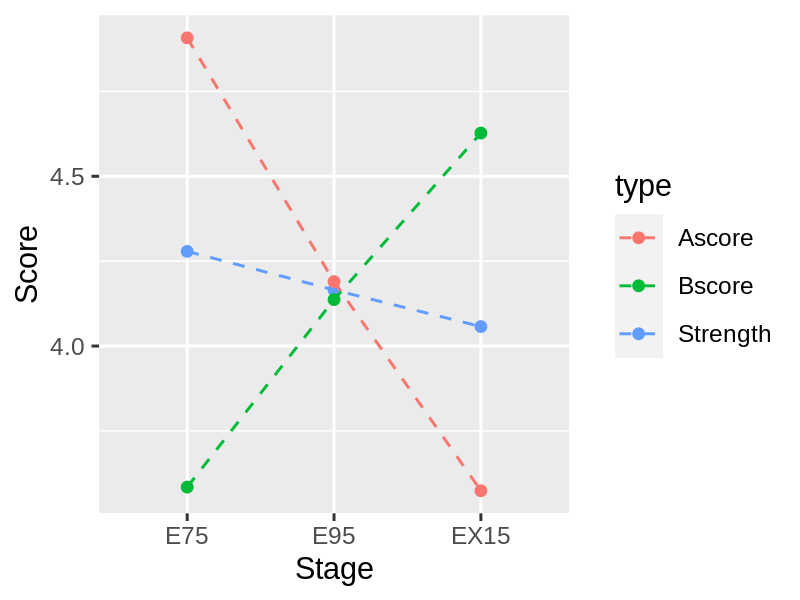

In [4]:
options(repr.plot.width=4,repr.plot.height=3,repr.plot.res=200)
saddleres %>% ggplot(aes(x=Stage,y=Score,color=type)) + geom_point() + geom_line(aes(group=type), linetype="dashed") #+ theme_Publication()

In [6]:
saddleres

Stage,type,Score
<fct>,<chr>,<dbl>
E75,Strength,4.278756
E95,Strength,4.165300
EX15,Strength,4.057320
E75,Ascore,4.907803
E95,Ascore,4.189786
EX15,Ascore,3.573800
E75,Bscore,3.584492
E95,Bscore,4.136855
EX15,Bscore,4.627364


circlize version 0.4.13
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: https://jokergoo.github.io/circlize_book/book/

If you use it in published research, please cite:
Gu, Z. circlize implements and enhances circular visualization
  in R. Bioinformatics 2014.

This message can be suppressed by:
  suppressPackageStartupMessages(library(circlize))




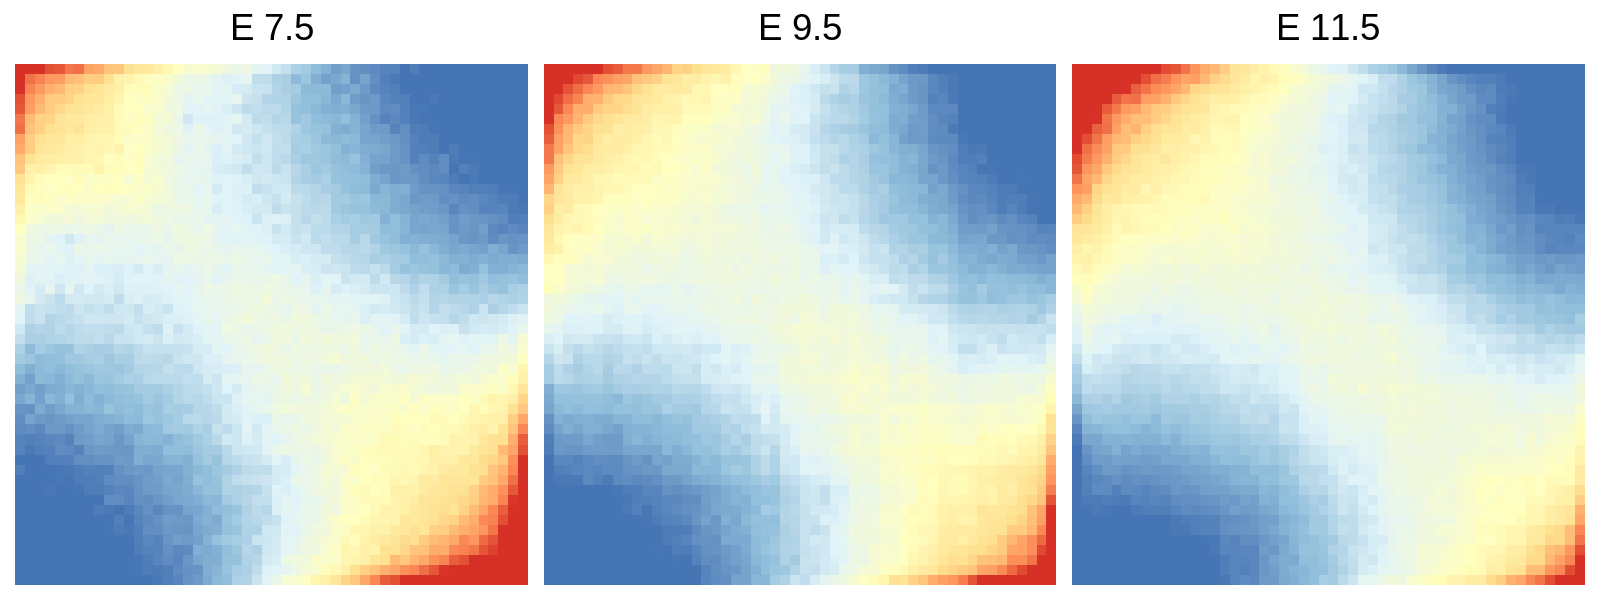

In [5]:
library(circlize)
col_fun = colorRamp2(seq(2,0.5,length.out = 7), c("#d73027","#fc8d59","#fee090","#ffffbf","#e0f3f8","#91bfdb","#4575b4"))

ht1 <- saddleDatamats[[1]] %>% Heatmap(cluster_columns = FALSE,cluster_rows=FALSE,col = col_fun, column_title = "E 7.5")
ht2 <- saddleDatamats[[2]] %>% Heatmap(cluster_columns = FALSE,cluster_rows=FALSE,col = col_fun, column_title = "E 9.5")
ht3 <- saddleDatamats[[3]] %>% Heatmap(cluster_columns = FALSE,cluster_rows=FALSE,col = col_fun, column_title = "E 11.5")


options(repr.plot.width=8,repr.plot.height=3,repr.plot.res=200)
draw(ht1+ht2+ht3,merge_legend=T,show_heatmap_legend=F)